# Grid Optimization Analysis
Create some visualizations of the Grid Optimization dataset to get a better idea of it.

In [1]:
import numpy as np
import qcportal as ptl
import mplcursors
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, DrawingArea, TextArea
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from sklearn import decomposition # PCA

In [2]:
# Interactive plots
%matplotlib notebook

## Loading the Data

In [3]:
CLIENT = ptl.FractalClient()
DATASET = CLIENT.get_collection('GridOptimizationDataset',
                                'OpenFF Trivalent Nitrogen Set 1')
MOLECULE_IDS = [
    DATASET.get_entry(index).initial_molecule for index in DATASET.df.index
]
MOLECULES = CLIENT.query_molecules(id=MOLECULE_IDS)
METADATA_ENTRIES = [
    DATASET.get_entry(index).object_map['default'] for index in DATASET.df.index
]
# get all grid optimization calculations from the entire dataset
ENTRIES = CLIENT.query_procedures(METADATA_ENTRIES)

# Expected number of optimization frames
NUM_FRAMES = 21

# Remove molecules that have no optimizations
GOOD_MOLECULES = []
GOOD_ENTRIES = []
for idx, entry in enumerate(ENTRIES):
    final_energies = entry.get_final_energies()
    if len(final_energies) != NUM_FRAMES:
        print(f"Molecule {idx:3} ({MOLECULES[idx].get_molecular_formula()}) has {len(final_energies)} frames")
    else:
        GOOD_MOLECULES.append(MOLECULES[idx])
        GOOD_ENTRIES.append(ENTRIES[idx])

Molecule  66 (C22Cl2H24NO6PS) has 0 frames
Molecule  83 (C16H37NO2P2S2) has 0 frames
Molecule  84 (C22H24NO2PS) has 0 frames
Molecule  85 (C20H21N3O4S) has 0 frames
Molecule 138 (C4H6N2O) has 0 frames
Molecule 141 (C19H13NO3S) has 0 frames
Molecule 157 (C31H45N3O8S3) has 0 frames
Molecule 160 (C21H22N2O6S2) has 0 frames
Molecule 175 (C28H22NO2P) has 0 frames
Molecule 193 (C22H24N6O6S2) has 0 frames
Molecule 204 (C12H21N2P) has 0 frames
Molecule 218 (BrC9H8N3) has 0 frames
Molecule 236 (C6H5N3) has 0 frames
Molecule 242 (C13H18N3O2) has 0 frames
Molecule 252 (C24H20NOP) has 0 frames
Molecule 277 (C12H11N2O3S) has 0 frames
Molecule 279 (C10H8N2O2) has 0 frames
Molecule 286 (C7H4INO3S) has 0 frames
Molecule 298 (C22H30N3P) has 0 frames


In [4]:
print(f"There are {len(GOOD_MOLECULES)} good molecules.")

There are 292 good molecules.


## Visualization

Get a better idea of what the data looks like using PCA.

In [5]:
# Create vectors of the energies
ENERGIES = np.zeros(shape=(len(GOOD_ENTRIES), NUM_FRAMES))

for idx, entry in enumerate(GOOD_ENTRIES):
    final_energies = entry.get_final_energies()
    for frame_idx in range(NUM_FRAMES):
        ENERGIES[idx][frame_idx] = final_energies[(frame_idx,)]
    # Normalize the energies by subtracting the minimum energy
    min_energy = np.min(ENERGIES[idx])
    ENERGIES[idx] -= min_energy

# Apply PCA to reduce to 2d for plotting
pca_2d = decomposition.PCA(n_components=2)
ENERGIES_2D = pca_2d.fit_transform(ENERGIES)

Based on the figure below, it seems increasing the two axes somehow correspond to the concavity of the plot. Increasing the y-value seems to increase the concavity of the optimization, while increasing the x-value seems to decrease the concavity of the optimization. Plots on the top left tend to be more "cup-shaped", while plots on the bottom right are more of an "upside-down cup". At any rate, we can see that plots with similar shape are certainly close together.

<IPython.core.display.Javascript object>


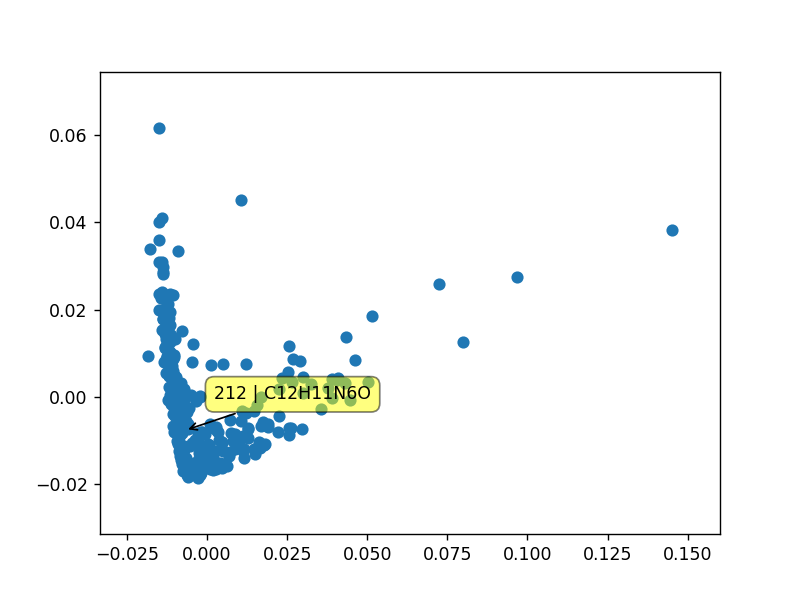

<IPython.core.display.Javascript object>


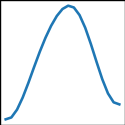

In [6]:
# Create a plot of the PCA - when one hovers over the points,
# they can see the normalized 1D scan for the point.
fig, ax = plt.subplots(1,1)
scatter_path = ax.scatter(ENERGIES_2D[:,0], ENERGIES_2D[:,1])


# Set up the figure that shows the plot.
scan_plot = DrawingArea(50, 50, 0, 0)
scan_fig = plt.figure(figsize=(1,1))
scan_ax = scan_fig.add_axes([0,0,1,1])
scan_ax.plot(np.arange(0, NUM_FRAMES, 1), ENERGIES[0])
scan_plot.add_artist(scan_fig)

def show_plot(event):
    """
    A callback that handles mouse events and shows the molecule
    in the plot.
    """
    mouse_hovering, info = scatter_path.contains(event)
    if mouse_hovering:
        # Index within the array where the event occurred.
        ind, = info["ind"]

        # Set the 1D scan plot to correspond to the point.
        scan_ax.clear()
        scan_ax.plot(np.arange(0,NUM_FRAMES,1), ENERGIES[ind])
    fig.canvas.draw_idle()
# Add the callback.
fig.canvas.mpl_connect('motion_notify_event', show_plot)


# Displays the molecule index and molecule formula in a text box
# when hovering over a point.
def make_annotation(selection):
    """Sets the annotation when hovering over a point."""
    index = selection.target.index
    selection.annotation.set_text(
        f"{index} | {GOOD_MOLECULES[index].get_molecular_formula()}"
    )
crs = mplcursors.cursor(ax, hover=True)
crs.connect("add", make_annotation)


plt.show()